# Ensemble Learning

Last revision: Wed  24 Dec 2020 9:14:00 AEST

Author: Omar Ghattas

## Introduction

In this lab we will explore one of the most important areas in machine learning, ensemble methods. We will dive deeper into the bias-variance decomposition, and then work through detailed examples of Bagging and Adaptive Boosting, two algorithms that have become central to modern day machine learning. In each section, the goal will be to illustrate the concept both mathematically and then through code, and then we follow up with a short explanation of existing implementations that you should use in practice. It is important to understand how these algorithms work and so you are strongly encouraged to try to write simple implementations of these algorithms in Python, even if we do not end up using these in practice.

**Note: this notebook has only been tested using Python 3.**

### Acknowledgements:
Random Forest Regression Section: this section (only) was taken from the the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas (one of the original sklearn developers); the original content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

## Recap: Bias Variance Decomposition

We begin by discussiong the Bias-Variance decomposition, a central theme in Statistics and Machine Learning. Assume that we are interested in estimating some population parameter $\theta$, and we have access to a finite dataset $D = \{X_1,\dots, X_n\}$, which we assume is independently sampled. To give a concrete example, suppose we are interested in estimating the average GPA of students in COMP9417, but we only have access to the GPA of a small subset of 22 randomly sampled students. The population here is all students in the course, and we must infer information about the true mean using only information about a small subset. 

When $\theta$ denotes the population mean, one standard estimator to use is the sample-mean:

$$
\hat{\theta} = \frac{1}{n} \sum_{i=1}^n X_i.
$$

However, this is only one estimator, and we could use others, for example, the sample median:

$$
\tilde{\theta}=\text{median}(X_1,\dots,X_n)
$$

or, for a silly example, we could simply choose to estimate $\theta$ by the second datapoint

$$
\dot{\theta} = X_2.
$$

These are all valid estimators of $\theta$, but of course some are better than others (obviously $\dot{\theta}$ will be a useless estimator in almost all examples. Bias and Variance of estimators are two metrics we may use to quantify how good an estimator actually is. 

### Bias

We first start with the mathematical definition and then explain the intuition behind that definition. Given an estimator $\hat{\theta}$ for population parameter $\theta$, we define the bias of $\hat{\theta}$ as

$$
\text{Bias}(\hat{\theta}) = \mathbb{E}[\hat{\theta}] - \theta,
$$

where $\mathbb{E}$ denotes expectation. The bias simply measures how far away the expected value of our estimator is from the truth. An estimator with zero bias is called an unbiased estimator. All else equal, an unbiased estimator is better than a biased estimator.

### Variance

The variance of an estimator $\hat{\theta}$, is denoted by $\text{Var}(\hat{\theta})$ and is defined in the usual way

$$
\text{Var}(\hat{\theta}) = \mathbb{E} [ ( \hat{\theta} - \mathbb{E}[\hat{\theta} ] )^2]
$$

### Interpretation - An important point
An important question arises here: what does it mean to take an expectation (or variance) of an estimator $\hat{\theta}$? How do we compute these values? For the purpose of this lab, we will side-step the proper mathematical definitions and try to answer this question in a more intuitive sense. We can think of our dataset $D$ as being just one of infinitely many datasets. Let's imagine that we have access to a black-box $B$ that we can query datasets from. We label these datasets: $D_1,D_2,\dots, D_{\infty}$, and for simplicity we assume that each dataset consists of the same number $n$ of samples. For clarity, we have:

\begin{align*}
D_1 &= \{ X^{(1)}_1, X^{(1)}_2,\dots,X^{(1)}_n \} \\
D_2 &= \{ X^{(2)}_1, X^{(2)}_2,\dots,X^{(2)}_n\}\\
D_3 &= \{ X^{(3)}_1, X^{(3)}_2,\dots,X^{(3)}_n\}\\
&  \vdots
\end{align*}

Now, assume that we have chosen an estimator $\hat{\theta}$. This estimator is a function of the dataset, so for each dataset, we can compute a new estimate. For example, if we wish to use the sample mean, then our estimate for each dataset would just be the sample-mean of each dataset:

\begin{align*}
\hat{\theta}_1 &= \overline{X}_1 = \frac{1}{n} \sum_{i=1}^n X_i^{(1)}\\
\hat{\theta}_2 &= \overline{X}_2 = \frac{1}{n} \sum_{i=1}^n X_i^{(2)}\\
&  \vdots
\end{align*}

and so on. Now, we can think of the quantity $\mathbb{E}[\hat{\theta}]$ as being the average value of $\hat{\theta}$ over an infinite number of datasets. Similarly, we can think of $\text{Var}(\hat{\theta})$ as the variance of $\hat{\theta}$ over an infinite number of datasets. 

Note that this is a purely theoretical construction because we do not have access to a black-box $B$ that allows us to generate multiple datasets (in fact we will usually only have access to a single dataset), and secondly even if we did have access to $B$, we cannot sample an infinite number of datasets. This theoretical construction does however help us understand the benefits of different estimators and has led to the proposal of many important algorithms in machine learning that have had great empirical success.

### Bias-Variance for Learning Functions
Up to this point, you should have understood the basic concepts underlying the bias-variance decomposition. We now tie this back into the machine learning framework. In a general (supervised) learning problem, we have access to a dataset $D$ which consists not only of feature vectors $X$, but also response values $y$, so that 

$$
D = \{(x_1,y_1),\dots,(x_n, y_n)\}.
$$

We assume that there exists some true (but unobservable) function $f$ that takes as input a feature vector $X$ and outputs a response $y$. We will also assume that the observed responses are corrupted by some additive noise. In other words, our assumption is that:

$$
y = f(x) + \epsilon, \qquad \epsilon \sim (0,\sigma^2),
$$

where the notation $\epsilon \sim (0,\sigma^2)$ means that $\epsilon$ is a random variable with zero mean and variance $\sigma^2$. One way to think about $\epsilon$ is that it represents measurement error. For example, if we are measuring temperature on a given day using a thermometer, then our measurement might consist of the `true` temperature, $f(x)$, plus some noise due to the usage of a cheap theormometer. The most common assumption is that $\epsilon$ is normally distributed, so we write: $\epsilon \sim N(0,\sigma^2)$.

Now, the goal of learning is to use the data $D$ to find an estimate of $f$, which we call $\hat{f}$, so that $f$ and $\hat{f}$ are as close as possible in some sense. One common way to do this is to learn a $\hat{f}$ that minimizes the Mean Squared Error (MSE) between $y$ and $\hat{f}$. So far in this course, we have seen many ways of computing such an estimate $\hat{f}$, for example, linear regression, SVMs, Neural Networks, etc. It turns out that regardless of how you choose to construct your estimate, there exists a decomposition of the MSE (the expected squared error of $\hat{f}$ on a previously unseen example, i.e. test MSE), called the Bias Variance Decomposition:

$$
\mathbb{E} [(y- \hat{f}(x))^2] = \left ( \text{Bias}(\hat{f}(x)) \right)^2 + \text{Var}(\hat{f}(x)) + \sigma^2,
$$

where as before, we have 

$$
\text{Bias}(\hat{f}(x)) = \mathbb{E} [\hat{f}(x)] - f(x).
$$

In other words, the MSE of $\hat{f}$ may be decomposed into a sum of three terms:

1. (Squared) Bias: As discussed earlier, bias captures how far an estimate is from its target. Intuitively, simple algorithms (i.e. those with few parameters, such as linear models) will have high bias, since the 'true' function $f$ is rarely linear). We will see that models with low flexibility (linear models) tend to have high bias, and those with high flexibility (neural nets will have low bias).

2. Variance: this captures how sensitive the learning method is to changes in the dataset. i.e. given two datasets $D_1$, $D_2$, how different are the corresonding estimates $\hat{f}_1(x)$ and $\hat{f}_2(x)$? We will see that flexible learning algorithms, such as neural nets, will have high variance. Intuitively, since neural nets are so powerful, they can fit pretty much any decision surface, so estimates on different datasets can vary greatly.

3. $\sigma^2$: this is called the irreducible error, and since our responses contain noise, this is the error we have to live with in our predictions, regardless of the learning algorithm we use.

It is important to understand why these factors contribute to the overall test error. A learning algorithm with high bias is unlikely to be able to fit the true function, and so will do poorly when asked to make a prediction on a new test point (underfitting). A learning algorithm with high variance will have a lot of flexibility, and so will fit the training data very well, but this does not necessarily mean it will be able to generalise well (overfitting).

It turns out that there is a trade-off between bias and variance. That is, learning algorithms that have low bias will tend to have high variance, and vice versa. In machine learning, we wish to find models that minimise MSE, and so we have to choose models that achieve the right balance between these two competing criteria.

### Illustrating the Bias-Variance Decomposition
In order to illustrate these concepts and hopefully make them more understandable, we will now work through an extended example in code. The idea is to assume we have access to the blackbox $B$, from which we will generate multiple datasets from, and build models of increasing complexity from. To start with, consider the function:

$$
f(x) = 0.001 x^3
$$

We next write a function to sample noisy examples from this function, with noise taken to be Normally distributed with mean zero and standard deviation $\sigma=0.1$. We will assume that the input values $x$ are uniformly distributed from $x=1$ to $x=10$, and this choice is completely arbitrary.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
# true function
f = lambda x: 0.001 * x**3

def f_sampler(f, n=100, sigma=0.1):    
    # sample points from function f with Gaussian noise (0,sigma**2)
    xvals = np.random.uniform(low=1, high=10, size=n)
    yvals = f(xvals) + sigma * np.random.normal(0,1,size=n)
    
    # build dataset D
    D = np.zeros(shape=(n, 2))
    D[:,0] = xvals; D[:,1] = yvals; 
    
    return D

Let's now generate $100$ samples from $f$, plot them, along with the true function super-imposed. Note that in practice we only hace access to the dataset of samples, and not the true function $f$.

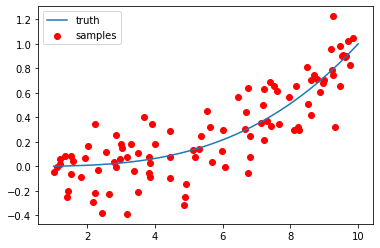

In [3]:
fsamples = f_sampler(f, 100, sigma=0.2)

xx = np.linspace(1,10,1000)
plt.plot(xx, f(xx), label="truth")
plt.scatter(*fsamples.T, color="red", label="samples")
plt.legend()
plt.show()

We can generate an infinite number of datasets (we have access to the blackbox) in this way. Let's consider 9 different datasets, call them $D_1,\dots,D_9$.

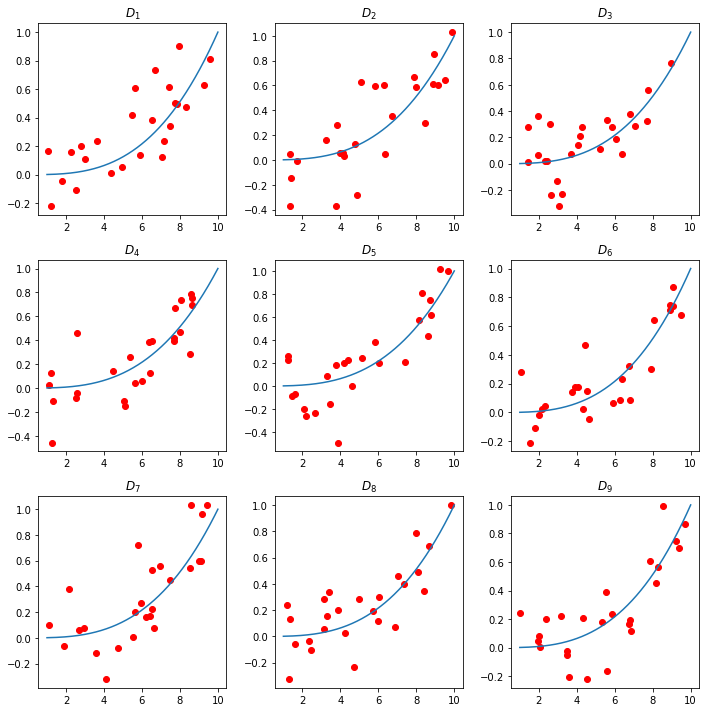

In [4]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
plt.tight_layout()
plt.show()

Hopefully from this we can see that from the same true function $f$, we can generate many datasets that look different. The idea now will be to fit a model to each of the datasets, and see how the fits vary from dataset to dataset. A simple model to begin with is linear regression (with a single feature). This model has high bias because it has a very strict assumption on the shape of the model, regardless of the data. It has low variance because models fit on different datasets will not vary too much. We can see this empirically for the 9 generated datasets, and we will plot the fitted models in green on each plot in the grid.

<ipython-input-5-e160126f5e6a>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mods[i] = np.array([mod.intercept_[0], mod.coef_[0]])
<ipython-input-5-e160126f5e6a>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mods[i] = np.array([mod.intercept_[0], mod.coef_[0]])
<ipython-input-5-e160126f5e6a>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creatin

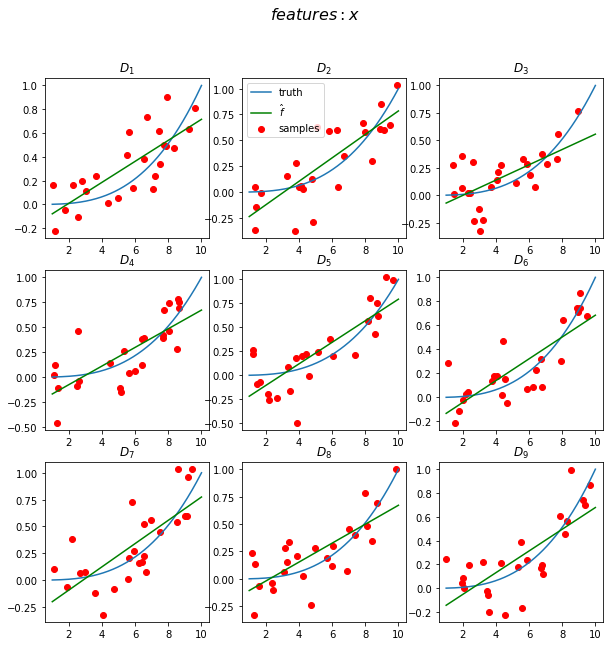

In [5]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)

mods = np.zeros((9, 2))      # store models
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
    
    # build model
    X = fsamples[:,0].reshape(-1,1)
    y = fsamples[:,1].reshape(-1,1)
    mod = LinearRegression().fit(X, y)
    lr = lambda x: mod.intercept_[0] + mod.coef_[0]*x
    mods[i] = np.array([mod.intercept_[0], mod.coef_[0]])
    ax.plot(xx, lr(xx), color="green", label="$\\hat{f}$")
    if i==1: ax.legend()
    
fig.suptitle("$features: x$", fontsize=16)
plt.show()

Note that the fitted model does not vary much from dataset to dataset. Linear models with a single feature do not have much ability to fit complicated trends in the data (they must be a straight line), and so will exhibit low variance, and high bias. Let's compute these quantities for our toy example at a single point, say $x_0 = 5$. 

The bias is the expected value of the model at $x_0$ minus the true value of $f$ at $x_0$, i.e. $f(x_0)$. Recall that in order to compute the expected value at $x_0$, we must be able to sample an infinite number of datasets, fit a model, then average. Here we will use the average of the predictions of the 9 models at $x_0$ as a proxy. To compute variance, we compute the variance of the predictions of all 9 models at $x_0$. We can see from the plot that linear regression has high bias, and low variance. Compare this picture to the picture we looked at earlier with the bias/variance targets.

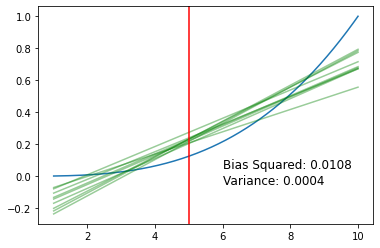

In [6]:
x0 = 5
x0_preds = np.zeros(9)
plt.plot(xx, f(xx))
for i in range(9):
    lr = lambda x: mods[i,0]+mods[i,1]*x
    plt.plot(xx, lr(xx), color="green", alpha=0.4)
    
    x0_preds[i] = lr(x0)
plt.axvline(x0, color="red")
plt.annotate(f'Bias Squared: {round((np.mean(x0_preds)-f(x0))**2,4)}', (6, 0.05), size=12, color='black')
plt.annotate(f'Variance: {round(np.var(x0_preds),4)}', (6, -0.05), size=12, color='black')
plt.show()

The above plot shows the $9$ fitted models (in blue), and the true function $f$ in blue. We see that $x_0=5$, all $9$ models seem to do quite poorly as they are unable to fit the curvature in the true model. The bias here is high because the estimate is consistently far away from the truth. Note however that all $9$ models more or less predict the same value for $x_0$, and so exhibit very lower variance.

We can now investigate a more complex model by adding polynomial features to the linear regression. As we add higher order terms, we will be able to fit more complicated (curvy) functions. $\hat{y} = a + bx + cx^2$

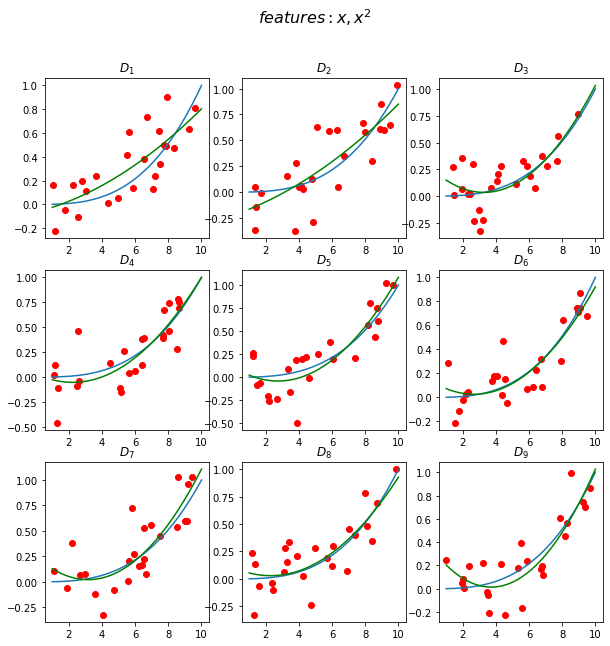

In [7]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)

mods = np.zeros((9, 3))      # store models
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
    
    # build model
    X = fsamples[:,0].reshape(-1,1)
    X = np.concatenate((X,X**2), axis=1)       # polynomial features
    y = fsamples[:,1].reshape(-1,1)
    mod = LinearRegression().fit(X, y)
    lr = lambda x: mod.intercept_[0] + mod.coef_[0][0]*x + mod.coef_[0][1]*x**2
    mods[i] = np.array([mod.intercept_[0], *mod.coef_[0]])
    ax.plot(xx, lr(xx), color="green", label="$\\hat{f}$")
fig.suptitle("$features: x, x^2$", fontsize=16)
plt.show()

Now that we have more flexibity (due to increasing the feature set to include quadratic terms), we see that learning algorithm can better fit the data, and we also see that there is slightly more variation across fits. Let's repeat our analysis above for $x_0=5$.

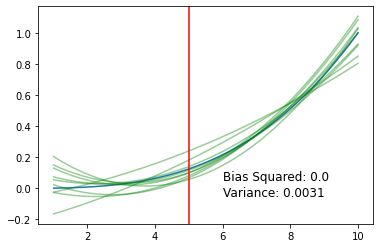

In [8]:
plt.plot(xx, f(xx))
for i in range(9):
    lr = lambda x: mods[i,0]+mods[i,1]*x+mods[i,2]*x**2
    plt.plot(xx, lr(xx), color="green", alpha=0.4)
    x0_preds[i] = lr(x0)
    
plt.axvline(x0, color="red")
plt.annotate(f'Bias Squared: {round((np.mean(x0_preds)-f(x0))**2,4)}', (6, 0.05), size=12, color='black')
plt.annotate(f'Variance: {round(np.var(x0_preds),4)}', (6, -0.05), size=12, color='black')
plt.show()

Let's keep adding more polynomial features: $a + bx + cx^2 + dx^3+ex^4 + fx^5 + g x^6$ and see what happens.

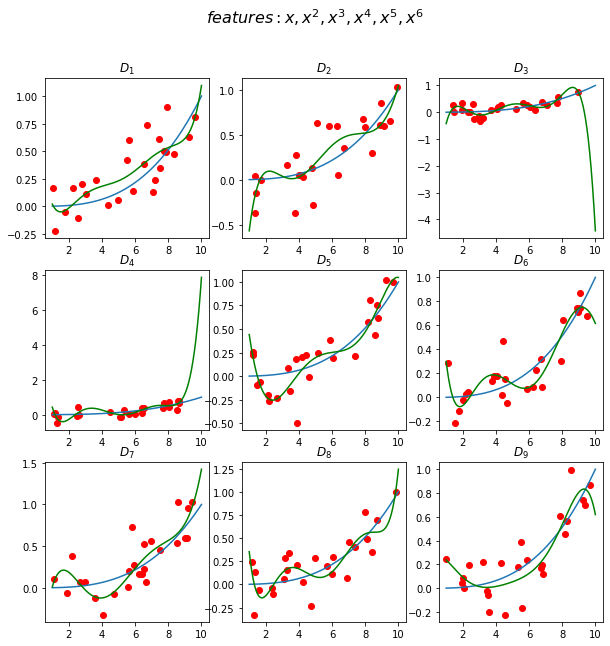

In [9]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
np.random.seed(10)

mods = np.zeros((9, 7))      # store models
for i, ax in enumerate(ax.flat):
    ax.plot(xx, f(xx), label="truth")
    fsamples = f_sampler(f, 25, sigma=0.2)
    ax.scatter(*fsamples.T, color="red", label="samples")
    ax.set_title(f"$D_{i+1}$")
    
    # build model
    X = fsamples[:,0].reshape(-1,1)
    X = np.concatenate((X, X**2, X**3, X**4, X**5, X**6), axis=1)       # polynomial features
    y = fsamples[:,1].reshape(-1,1)
    mod = LinearRegression().fit(X, y)
    lr = lambda x: mod.intercept_[0] + mod.coef_[0][0]*x + mod.coef_[0][1]*x**2 +\
    mod.coef_[0][2]*x**3 + mod.coef_[0][3]*x**4 + mod.coef_[0][4]*x**5 + + mod.coef_[0][5]*x**6
    mods[i] = np.array([mod.intercept_[0], *mod.coef_[0]])
    ax.plot(xx, lr(xx), color="green", label="$\\hat{f}$")
    
fig.suptitle("$features: x, x^2, x^3, x^4, x^5, x^6$", fontsize=16)
plt.show()

Now the models have a very large amount of flexibility, and are able to fit more and more complex fits. We can see from the plot above that the fitted models vary greatly from dataset to dataset.

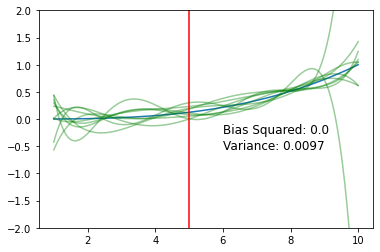

In [10]:
plt.plot(xx, f(xx))
for i in range(9):
    lr = lambda x: mods[i,0] + mods[i,1]*x + mods[i,2]*x**2 +\
    mods[i,3]*x**3 + mods[i,4]*x**4 + mods[i,5]*x**5 + + mods[i,6]*x**6
    plt.plot(xx, lr(xx), color="green", alpha=0.4)
    x0_preds[i] = lr(x0)
    
plt.axvline(x0, color="red")
plt.ylim(-2,2)
plt.annotate(f'Bias Squared: {round((np.mean(x0_preds)-f(x0))**2,4)}', (6, -0.25), size=12, color='black')
plt.annotate(f'Variance: {round(np.var(x0_preds),4)}', (6, -0.55), size=12, color='black')
plt.show()

We see that as the complexity increases, so too does the variance. As we increase the complexity of the model, it has more and more flexibility to fit complex functions. The problem is that for different datasets, the models end up fitting the noise in the data. The high variance comes from the fact that for different datasets, we can get wildly different models. So there is a tradeoff here, which is known as the bias variance decomposition. If we want to reduce test error, then we want to be able to reduce the bias AND reduce the variance, but as we reduce bias sufficiently, the variance begins to increase.

Now, let's consider a more interesting function:

$$
f(x) = 0.00002 x^3 + 0.2 \cos(x^{1.2})
$$

and we will generate a larger number of datsets to play with, say $80$.

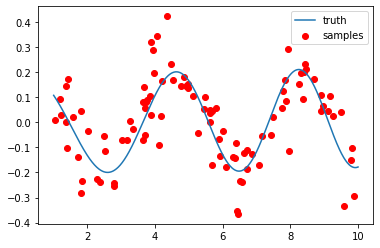

In [11]:
np.random.seed(10)

# true function
f = lambda x: 0.00002 * x**3 + 0.2 * np.cos(x**1.2)

fsamples = f_sampler(f, 100, sigma=0.1)

xx = np.linspace(1,10,1000)
plt.plot(xx, f(xx), label="truth")
plt.scatter(*fsamples.T, color="red", label="samples")
plt.legend()
plt.show()

Here we will generate $80$ datasets, and for each dataset fit a model. We will do so using regression with polynomial features, from degree $1$ to degree $9$. We plot each of the fitted models in blue, the true function in red, and we further plot the averaged value of the $80$ fitted models in orange, which is our proxy for $\mathbb{E}(f)$.

In [12]:
nmb_datasets = 80
xx_len = 1000
np.random.seed(10)

# generate datasets
datasets = np.array([f_sampler(f, 25, sigma=0.2) for _ in range(nmb_datasets)])
xx = np.linspace(1,10, xx_len)

preds = np.zeros(shape=(9, nmb_datasets, xx_len)) # store all predictions for all models

for deg in range(1, 10):
    Xs = np.array([D[:,0].reshape(-1,1) for D in datasets])
    ys = np.array([D[:,1].reshape(-1,1) for D in datasets])
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    Xs = np.array([poly.fit_transform(X) for X in Xs])        # get polynomial feature matrix
    
    # fit models on all datasets
    lrs = np.array([LinearRegression().fit(X, y) for (X,y) in zip(Xs, ys)])
    
    # predictions on range xx 
    xx_poly = poly.fit_transform(xx.reshape(-1,1))
    preds[deg-1,:,:] = np.array([mod.predict(xx_poly) for mod in lrs]).reshape(nmb_datasets, xx_len)
    

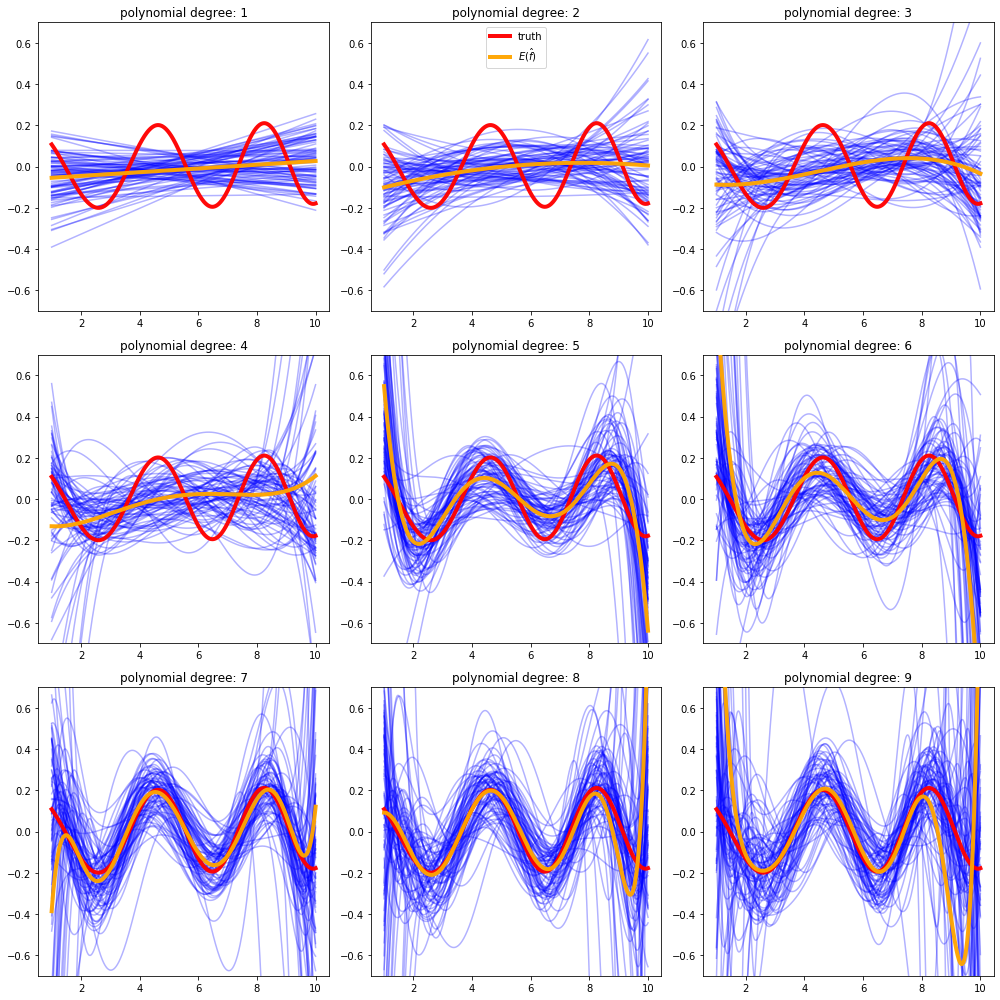

In [13]:
fig, ax = plt.subplots(3,3, figsize=(14,14))
truth = f(xx)
for j, ax in enumerate(ax.flat):
    avg_pred = np.mean(preds[j], axis=0)
    ax.plot(xx, truth, color="red", linewidth=4, alpha=10, zorder=20, label="truth")
    ax.plot(xx, avg_pred, color="orange", linewidth=4, alpha=10, zorder=20, label="$E(\\hat{f})$")    
    for i in range(nmb_datasets):
        ax.plot(xx, preds[j, i], alpha=0.3, color="blue", zorder=1)
        ax.set_title(f"polynomial degree: {j+1}")
        ax.set_ylim(-0.7,0.7)
    if j==1: ax.legend(loc="upper center")
plt.tight_layout()
plt.show()

Note that we should ignore the wild behaviour at the tails for this analysis, since this is caused by the way we build the model using linear regression. To get a better idea of the bias variance trade-off we should restrict attention to points in the middle 90\% or so.

Now, using the above data, we will try to visualise the bias and variance at each of the points on the $x$-axis.

In [14]:
variances = np.zeros(shape=(9, xx_len))
bias_sq = np.zeros(shape=(9, xx_len))
for i in range(9):
    variances[i,:] = np.var(preds[i], axis=0)
    bias_sq[i,:] = (np.mean(preds[i], axis=0) - f(xx))**2

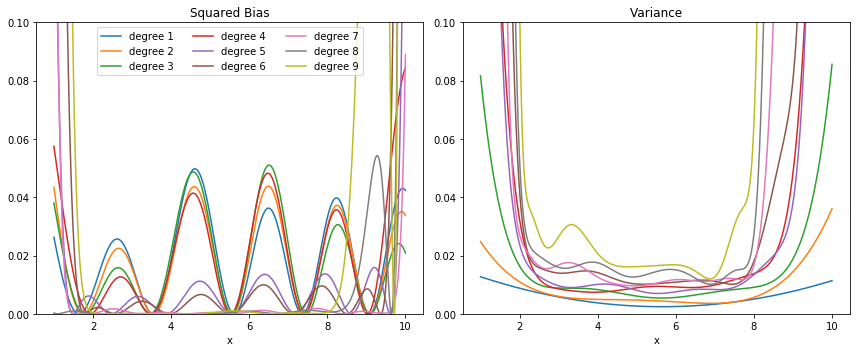

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
for i in range(9):
    ax1.plot(xx, bias_sq[i], label=f"degree {i+1}")
    ax2.plot(xx, variances[i])
    ax1.set_ylim(0,0.1)
    ax2.set_ylim(0,0.1)
    ax1.set_xlabel("x"); ax2.set_xlabel("x")
    ax1.set_title("Squared Bias")
    ax2.set_title("Variance")
ax1.legend(loc="upper center", ncol=3)
plt.tight_layout()

Exercises:
1. Look at the above plot carefully, does it look like you would expect? Which models have highest variance? Which have high bias?
2. Rerun the experiments above with a function of your own

### Bias-Variance Decomposition: So what?

Up till now, we have focused on understanding what the Bias-Variance decomposition means, but we haven't really seen why it is such an important concept. In the rest of the lab we will explore how the decomposition has motivated many important learning algorithms, such as Random Forests.

## Ensemble Learning: Bootstrap Aggregation (Bagging)

The Bias-Variance Decomposition tells us that a good learning algorithm is one that has low bias and low variance. Bootstrap Aggregation (Bagging) is an algorithm that attempts to build better models by reducing variance. Let's consider the example of a decision tree. Note that for this case, we will focus on classification error, and so the bias-variance decomposition does not have the same mathematical derivation as we saw above for the regression case with squared error, but the bias and variance still play analagous roles. 

In the following, we will repeat our analysis from before but for classification trees. We generate 9 datasets using the `make_blobs` function, so that all have the same cluster centers but points are sampled with some noise. We then build a decision tree of `max_depth=3` to each dataset and visualise. The idea will be to show that Decision Trees exhibit very high variance, which should be expected since we know that given enough depth, decision trees can fit any surface.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

# Helper function for visualising classifiers and decision surfaces    
def visualize_classifier(model, X, y, ax=None, cmap='rainbow', title=None):
    
    # reference: Python Data Science Handbook by Jake VanderPlas
    ax = ax or plt.gca()
    
    # Plot the training points
    
    if np.any(y==-1):
        y[y==-1] = 0.   # fix to get scatter c=y arg working when we use -1,1 coding
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
                        clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # compute predictions on grid
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    if np.any(Z==-1):     # fix to get c=y working
        Z[Z==-1] = 0

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    if title:
        ax.set_title(title)

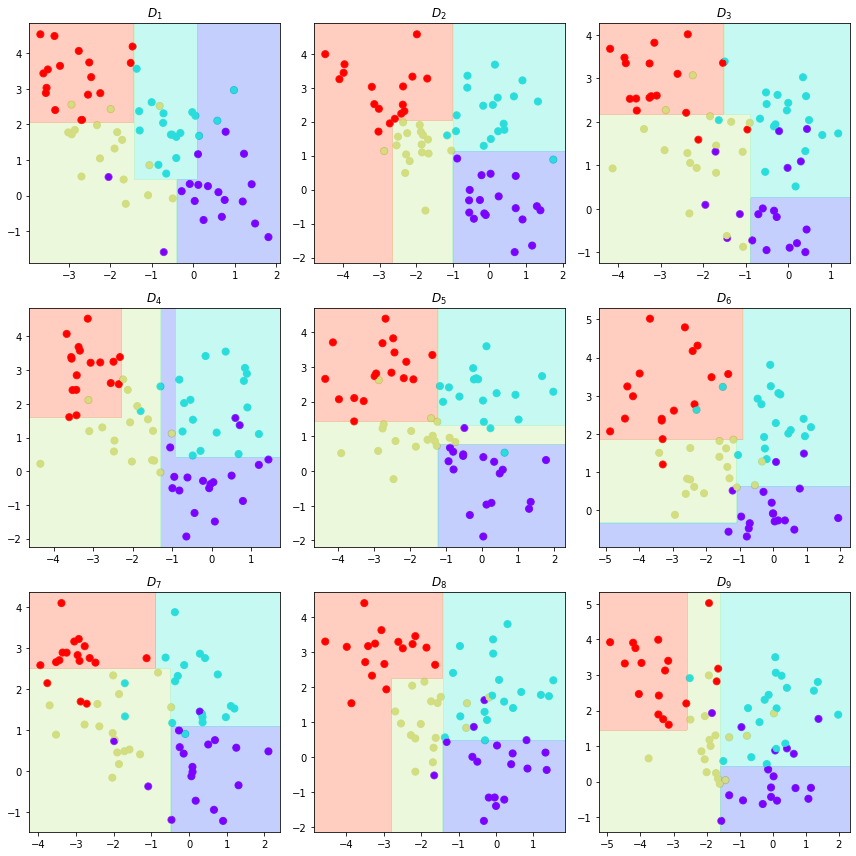

In [4]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
centers = [[0,0], [0,2], [-2,1], [-3,3]]
for j, ax in enumerate(ax.flat):
    X, y = make_blobs(n_samples=70, 
                      centers=centers, 
                      random_state=j, 
                      cluster_std=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')
    model = DecisionTreeClassifier(max_depth=3).fit(X,y)
    visualize_classifier(model, X, y, ax=ax, title=f"$D_{j+1}$")
    
plt.tight_layout()
plt.show()

It is clear from the above plots that given different datasets from the true clusters, Decision trees can fit a very wide range of models (different partitions of the input space), and so can very easily overfit.

Exercises:
1. Try increasing the max_depth parameter of the Decision Trees, what do you observe? Why?
2. What happens as you vary the `cluster_std` parameter of the data generating function (this plays the role of $\sigma$)? Explain why.
3. How would you combine decision trees to get more stable (lower variance) predictions ?

### Bagging (Wisdom of Crowds)

The idea of Bagging is motivated by the desire to reduce variance. The idea is simple: instead of focusing on changing the learning algorithm (Decision Trees) in this case, we instead focus on the way the learning algorithm is fit. Given a (single) dataset $D = \{(x_1,c_1),\dots,(x_n,c_n)\} $, where $x_i$ is the feature vector, and $c_i$ is the cluster label, we create $K$ bootstrap samples from this dataset, called $B_1,\dots,B_K$, each of size $m$. A bootstrap sample is simply a new dataset randomly sampled (with replacement) from the original dataset. We then fit a decision tree to each bootstrap sample, resulting in a total of $K$ models, denote them by $h_1,\dots, h_K$. Then, our Bagging classifier, $C$, on a new point $x^*$ simply returns:

\begin{align*}
    C(x^*) = \text{majority}\{h_1,\dots,h_K\}.
\end{align*}

In other words, given a new test point, each of the $K$ models returns a predicted class, and the ensemble classifier returns the majority vote. Think back to our initial discussion of the blackbox data generating process - the idea behind bootstrapping is somewhat trying to approximate this process by randomly sampling to create datasets. You can also think of this algorithm as utilising the wisdom of crowds: on their own each model (seeing a limited dataset) might overfit or predict poorly, but the combination of many models avoids this, and gives us very stable results since we now rely on majority of models to return a particular prediction.

### Variance Reduction
As long as the bootstrap samples are sampled randomly and with repalcement, then the bootstap samples are independent of each other. However, to reduce variance, we must ensure that the resulting decision trees built on the bootstrap samples are also independent (for a formal explanation, see the tutorial). To achieve independent models, there are two main approaches:

1. Randomize across samples (this is what we are doing with bootstrap aggregation)
2. Randomize across features (Random Forest does this, along with randomizing over samples)

We now try to implement some of the above in code. Note that whilst we restrict ourselves to Decision trees in the above, this idea is general and can be extended to any class of models, or even combinations of different models. We refer to the individual building blocks of the ensemble learner as base learners.

We will implement a `BaggingTree` class.

In [5]:
class BaggingTree():
    
    '''A (very) simple Bagging Tree Class'''
    
    def __init__(self, nComponents, sComponents, max_depth):
        self.nComponents = nComponents                 # number of base learners
        self.sComponents = sComponents                 # size of the bootstap samples (m)
        self.max_depth = max_depth                     # max depth of each base learner
    
    def create_K_bootstrap_of_size_m(self, X, y):
        # Given dataset X,y with n samples, create K bootstrap samples each of size sComponents
        n = X.shape[0]
        B_idxs = [np.random.choice(np.arange(n), size=self.sComponents, replace=True) 
                  for _ in range(self.nComponents)]
        B = [(X[B_idxs[i]], y[B_idxs[i]]) for i in range(self.nComponents)]
        self.BootstapSamples = B
    
    def fit(self, X, y):
        # fit the nComponents base learners to the bootstap samples
        self.create_K_bootstrap_of_size_m(X, y)
        self.baseClfs = [DecisionTreeClassifier(max_depth=self.max_depth).fit(
            self.BootstapSamples[i][0], 
            self.BootstapSamples[i][1]) for i in range(self.nComponents)]
        
    def predict(self, x):
        # predict class of test point x by taking majority vote of the base classifier predictions
        # x must be a numpy array of shape (?, nfeatures), where ? is anything
        
        # make sure x is an array
        x = np.array(x)
        
        # avoid shape issues with single point predictions
        if len(x.shape) < 2:
            x = x.reshape(1,-1)
        
        nTest = x.shape[0]
        
        # compute individual predictions
        preds = np.array([mod.predict(x) for mod in self.baseClfs])

        # compute majority vote (majority vote in each column of preds)
        mvs = np.array([np.bincount(preds[:,i]).argmax() for i in range(nTest)])
            
        return mvs

Now, let's repeat the experiment at the beginning of the bagging section and generate $9$ datasets, each time fitting our Bagging Tree classifier.

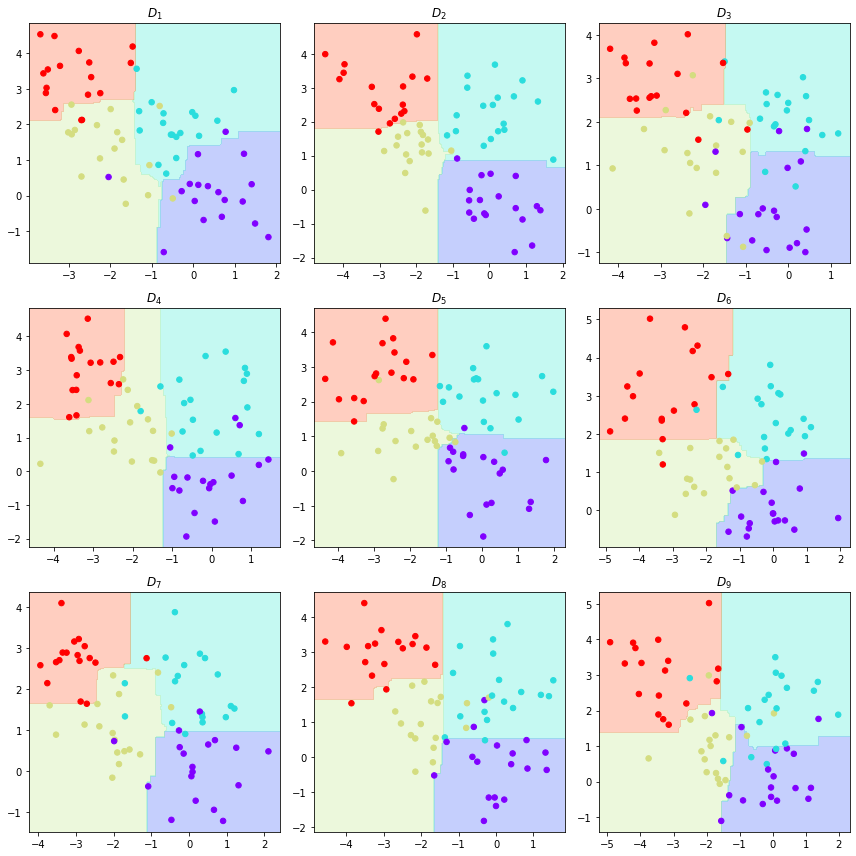

In [6]:
fig, ax = plt.subplots(3,3, figsize=(12,12))
for j, ax in enumerate(ax.flat):
    X, y = make_blobs(n_samples=70, 
                      centers=centers, 
                      random_state=j, 
                      cluster_std=0.8)
    BT = BaggingTree(100, 50, max_depth=3)
    BT.fit(X,y)
    visualize_classifier(BT, X, y, ax, title=f"$D_{j+1}$")

plt.tight_layout()
plt.show()

It should be clear that we have a model with significantly less variance than using a single Decision tree classifier.

### Feature Bagging
So far, we have seen one type of randomization, namely that of randomizing across samples to create our bootstrap samples. Another important type of randomization is randomization across features (Random Forests implement both types of randomization). We now describe what it means to randomize across features. Assume that the inputs $x$ are $p$ dimensional vectors, so that we have $p$ features in total. Instead of training a base learner in $p$-dimensional space, we randomly pick a subset of $s < p$ features, and train the base classifier on just those. 

For example, if we have $p=10$ features, and $s=3$, we would randomly pick a subset of 3 features to look at, and train a decision tree on this reduced $3$ dimensional problem. We can view this as feature-bagging, as opposed to the sample-bagging we saw before. 

The goal of randomization is to make the resulting predictors (trained base classifiers) as independent of each other as possible, so that we get an overall reduction in variance. If only sample-bagging is performed, there is still a risk that all models will give more weight to the same features (those that seem important for this particular dataset), and so the trained classifiers end up being quite correlated. Randomizing features ensures that this does not happen.

Exercise:
1. Augment the `BaggingTree()` class to implement a feature-bagging method (call this resulting class RandomForest')

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

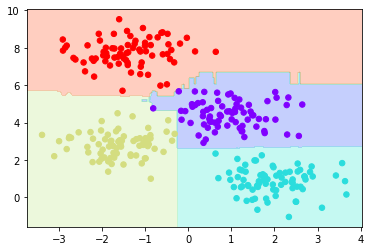

In [8]:
from sklearn.ensemble import RandomForestClassifier

X, y = make_blobs(n_samples=300, centers=4,random_state=0, cluster_std=0.7)
model = RandomForestClassifier(n_estimators=100, random_state=0).fit(X,y)
visualize_classifier(model, X, y);

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the ``RandomForestRegressor``, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation:

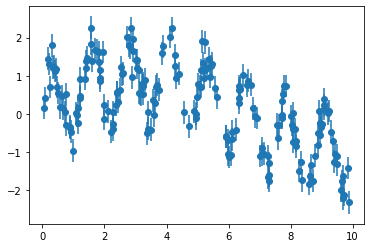

In [9]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))
    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best fit curve as follows:

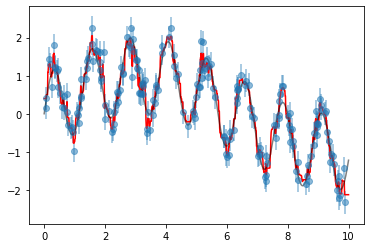

In [10]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. As you can see, the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

We previously looked at the hand-written digits data, and we use that again here to see how the random forest classifier can be used in this context.

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

To remind us what we're looking at, we'll visualize the first few data points:

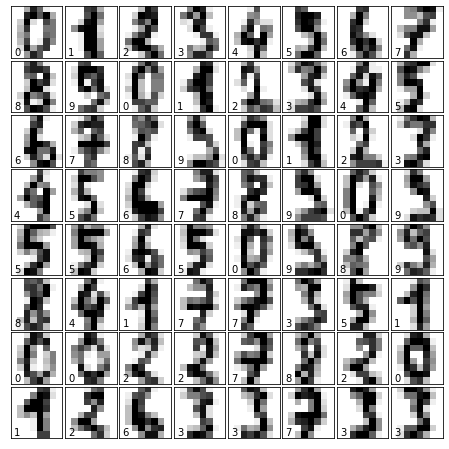

In [12]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a random forest as follows:

In [13]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:


In [14]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       1.00      0.98      0.99        44
           2       0.95      1.00      0.98        42
           3       0.98      0.96      0.97        46
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.96      0.98      0.97        46

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



And for good measure, plot the confusion matrix:


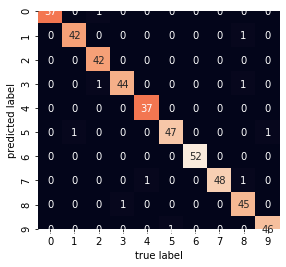

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We find that a simple, untuned random forest results in a very accurate classification of the digits data.

### Summary of Random Forests

This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.

**Question:** What advantages does the random forests method have?

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the ``predict_proba()`` method).
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

**Question:** What disadvantages does random forests method have?

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

## Adaptive Boosting (AdaBoost)

Boosting is a different but equally important ensemble technique that has been extremely successful in machine learning. The idea here, as in Bagging, is to combine various base classifiers into a single classifier. The difference here though is that the classifiers are no longer required to be independent, in fact the classifiers are built in such a way that at each iteration, a classifier is trained on the mistakes of the previous classifier.

You should think about Adaptive Boosting as converting a weak learner (an algorithm that is able to achieve results that are slightly better than guessing) into a strong learner (an algorithm that can achieve a low error rate). In this lab we will consider Decision stumps as our weak learner (these are depth 1 decision trees, so just a single if statement (i.e. just a linear classifier)), and we will combine them to be able to learn complicated decision surfaces. We repeat here the AdaBoost pseudocode from lectures for reference, and defer mathematical detail to the tutorial.

Input: data $D=(X,y)$, ensemble size $T$, learning algorithm $A$ (decision stump)
Output: weighted ensemble of models

1. Initialise weights: $w_{1i} \leftarrow 1/|D|$ for all $x_i \in D$
2. for $t=1, \dots, T$:
    - run $A$ on $D$ with weights $w_{ti}$ to produce a model $M_t$
    - calculate weighted error $\epsilon_t$
    - $\alpha_t \leftarrow \frac{1}{2} \log \frac{1-\epsilon_t}{\epsilon_t}$
    - $w_{(t+1)i} \leftarrow \frac{w_{ti}}{2\epsilon_t} $ for misclassified instances $x_i \in D$
    - $w_{(t+1)j} \leftarrow \frac{w_{ti}}{2(1-\epsilon_t)} $ for correctly classified instances $x_j \in D$
3. return $M(x) = \text{sign} \left ( \sum_{t=1}^T \alpha_t M_t(x) \right )$

To describe this in words, in adaptive boosting, we build a model composed of $T$ weak learners from a set of weak learners. At step $t$, we pick a model from the set of weak learners that minimises weighted error:
	\begin{align*}
		\epsilon_t = \sum_{i=1}^n w_{t-1, i} \mathbb{I}\{y_i \neq \hat{y}_i\}
	\end{align*}
where $w_{t-1,i}$ is the weight at the previous step for observation $i$, and $\mathbb{I}\{y_i \neq \hat{y}_i\}$ is equal to $1$ if $y_i \neq \hat{y}_i$ and zero otherwise. We do this for a total of $T$ steps, which gives us a boosted model composed of $T$ base classifiers:
$$
M(x)= \sum_{t=1}^T \alpha_t M_t(x)
$$
where $\alpha_t$ is the weight assigned to the $t$-th model. Classification is then carried out by assigning a point to the positive class if $M(x)>0$ or to the negative class if $M(x)<1$.

We will now implement a simple Boosting Trees class from scratch. We can make use of the `sample_weight` argument in the `fit()` of the `DecisionTreeClassifier` method to assign different weights to the individual data points. 

(**note:** you may be concerned that the decision tree implementation in scikit learn does not actually minimise $\epsilon_t$ even when weights are assigned, but we will ignore this detail for now).

First, we will generate some data, and learn a decision stump (linear boundary), we will then imlpement our Boosting tree class and demonstrate its performance on the same dataset.

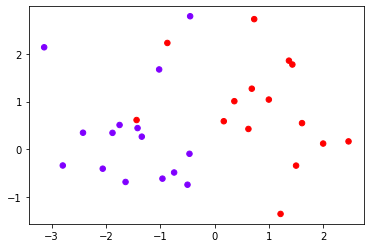

In [15]:
np.random.seed(2)
n_points = 30
X, y = make_blobs(n_points, 2, centers=[(-1,0.5), (1,0.5)])
plt.scatter(*X.T, c=y, s=30, cmap='rainbow')
plt.show()

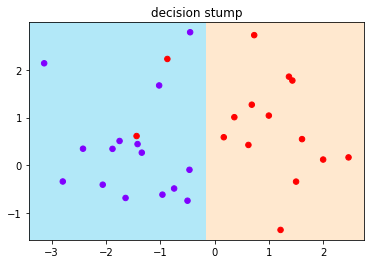

In [16]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X, y)
visualize_classifier(dt, X, y, title='decision stump')

In [27]:
def weighted_error(w, y, yhat):
    return np.sum(w*(y != yhat))

class BoostingTrees():
    '''A (very) simple Boosting Tree Class'''
    
    def __init__(self, nComponents):
        self.nComponents = nComponents
        self.alphas = np.zeros(self.nComponents)
        self.baseClfs = []
    
    def fit(self, X, y):
        
        # make sure using {-1,1} coding for binary labels
        if np.any(y==0):
            y[y==0] = -1   
        
        n = X.shape[0]
        
        # store weights, initialise to uniform weight
        w = np.zeros((self.nComponents+1, n))
        w[0] = np.ones(n)/n
        
        # run boosting steps
        for t in range(self.nComponents):
            
            # select weak classifier (decision stumps) that minimises WEIGHTED error
            dt = DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w[t])

            # compute predictions from current model
            yhat = dt.predict(X)

            # comptue weighted error epsilon_t
            eps_t = weighted_error(w[t], y, yhat)

            # compute alpha_t (model weight)
            alpha_t = 0.5 * np.log((1-eps_t)/eps_t)

            # update weights for next round 
            for i in range(n_points):
                if y[i] == yhat[i]: 
                    # correctly classified instances
                    w[t+1, i] = w[t, i]/(2 * (1-eps_t))
                else:
                    # misclassified instances
                    w[t+1, i] = w[t, i]/(2 * eps_t)

            # save model 
            self.alphas[t] = alpha_t
            self.baseClfs.append(dt)
 
    def predict(self, x):
        # predict class of test point x by computing M(x) = sign(sum_t alpha_t M_t(x))
        # x must be a numpy array of shape (?, nfeatures), where ? is anything
        
        # make sure x is an array
        x = np.array(x)
        
        # avoid shape issues with single point predictions
        if len(x.shape) < 2:
            x = x.reshape(1,-1)
        
        # compute individual predictions
        ind_preds = np.array([m.predict(x) for m in self.baseClfs])
        
        # weight individual predictions by alphas
        weighted_preds = np.dot(self.alphas, ind_preds)
        
        # predictions are signs of weighted_preds
        preds = np.sign(weighted_preds)
        
        return preds        

Let's try out this class for an increasing number of components from $2,\dots,26$. We will see that we will be able to combine many linear classifiers (decision stumps) to be able to learn complicated decision surfaces in an automated fashion. 

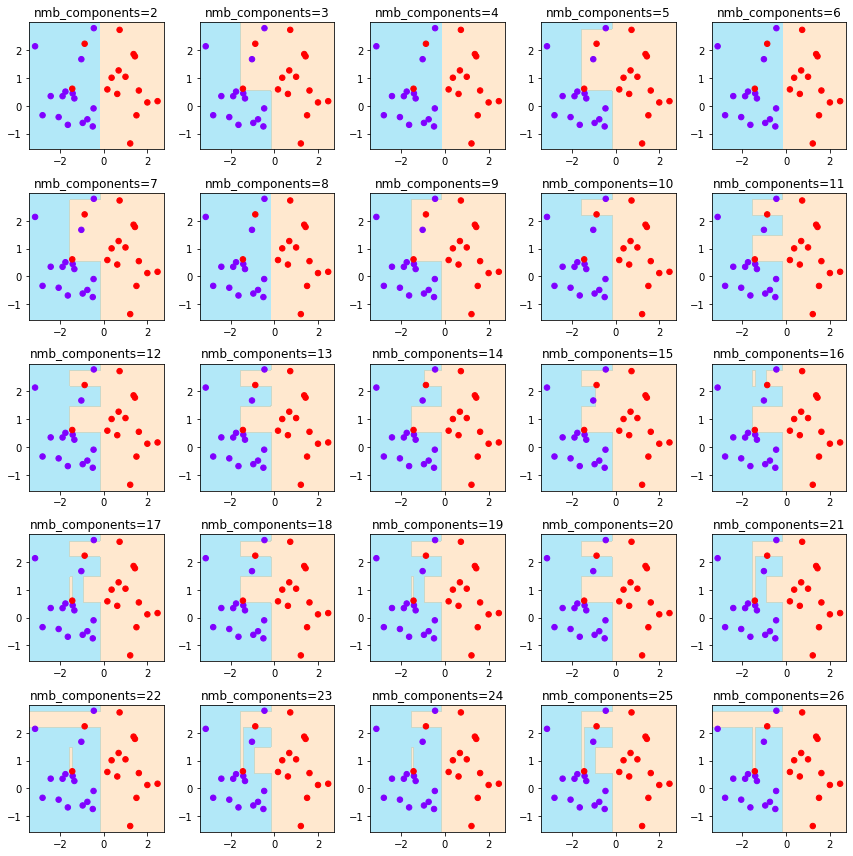

In [28]:
fig, ax = plt.subplots(5,5, figsize=(12,12))
titles = [f"nmb_components={i}" for i in range(2,28)]
for i, ax in enumerate(ax.flat):
    BT = BoostingTrees(nComponents=i+2)
    BT.fit(X,y)
    visualize_classifier(BT, X, y, ax, title=titles[i])
plt.tight_layout()
plt.show()

## Example: Boosted Trees for Classifying Digits

In practice, we will use the sklearn implementation of AdaBoost, and here we re-run our digit classification analysis but using the AdaBoost class.

In [32]:
from sklearn.ensemble import AdaBoostClassifier

In [33]:
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, criterion='entropy'),
                           n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

We can take a look at the classification report for this classifier:


In [34]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.63      0.87      0.73        31
           2       0.64      1.00      0.78        28
           3       0.89      0.83      0.86        48
           4       0.97      0.88      0.93        42
           5       0.94      0.90      0.92        50
           6       0.92      1.00      0.96        48
           7       0.83      0.98      0.90        41
           8       0.98      0.63      0.76        75
           9       0.85      0.78      0.82        51

    accuracy                           0.86       450
   macro avg       0.86      0.89      0.86       450
weighted avg       0.88      0.86      0.86       450



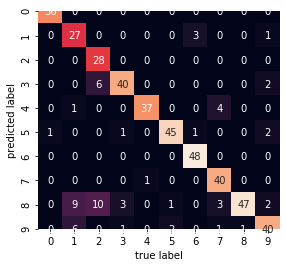

In [35]:
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');